In [243]:
from pathlib import Path
import pandas as pd
import numpy as np
from nilearn import image, masking, plotting
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
import pickle
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
project_dir = Path('/data/nielsond/meld/')
%pwd
%cd {project_dir}
%pwd

/spin1/users/nielsond/meld


'/spin1/users/nielsond/meld'

In [115]:
bids_dir = Path('data/voice/')
aprocdir = Path('data/voice/derivatives/afni_proc2')
nbdir = Path('notebooks')
mask_path = aprocdir/'group_full_mask.nii.gz'
mask_img = image.load_img(mask_path.as_posix())
outdir = Path('data/voice/derivatives/meld')
stim_dir = bids_dir/'afni_stim'
#!rm -rf {outdir}
singularity_image = Path('singularity/meldlocal-2017-12-13-11dcc4d4be31.img')
swarm_path = Path('proc_swarm_meld_voice.cmd')
log_dir = Path('swarm_log')

# Process replicability experiment

In [7]:
# Load all the meld thresholded t-maps
def get_complete_runs(outdir, run_name, rns):
    repl_paths = sorted(outdir.glob(run_name))
    complete_runs = [int(rp.parts[-1].split('_')[2]) for rp in repl_paths if rp.parts[-1].split('_')[2] not in ['noi','nods']]
    failed_runs = [rn for rn in rns if rn not in complete_runs]
    return repl_paths, complete_runs, failed_runs

In [166]:
run_name = '*repl-nods_???_t_thresh.nii.gz'
rns =range(2,102)
repl_paths, complete_runs, failed_runs = get_complete_runs(outdir, run_name, rns)

In [167]:
run_name = '*repl-nods-noi_???_t_thresh.nii.gz'
rns =range(2,102)
noi_paths, noi_complete_runs, noi_failed_runs = get_complete_runs(outdir, run_name, rns)

[75, 86]

In [10]:
#stim_perm_file = Path('stim_perms.pklz')
#with stim_perm_file.open('rb') as h:
#    n_stims = pickle.load(h)

In [183]:
# Load the results with everything

true_path = 'data/voice/derivatives/meld/run_repl-nods-perm6_000_t_thresh.nii.gz'
true_dat = masking.apply_mask(image.load_img(true_path), mask_img)

noi_true_path = 'data/voice/derivatives/meld/run_repl-nods-noi-perm6_000_t_thresh.nii.gz'
noi_true_dat = masking.apply_mask(image.load_img(noi_true_path), mask_img)

In [268]:
def get_metrics(img_dat, true_dat, sign = 1):
    img_bool = np.abs(img_dat) > 0
    true_bool = np.abs(true_dat) > 0
    img_pos = img_dat > 0
    img_neg = img_dat < 0
    true_pos = true_dat > 0
    true_neg = true_dat < 0
        
    tp = np.logical_and(img_bool, true_bool).sum()
    fp = np.logical_and(img_bool, np.logical_not(true_bool)).sum()
    tn = np.logical_and(np.logical_not(img_bool), np.logical_not(true_bool)).sum()
    fn = np.logical_and(np.logical_not(img_bool), true_bool).sum()
    s = np.logical_and(true_pos, img_neg).sum() + np.logical_and(true_neg, img_pos).sum()
    dice =  (2 * tp) / ((2 * tp) + fp + fn)
    #tpr = tp/(tp+fn)
    #tnr = tn/(tn+fp)
    #ppv = tp/(pt+fp)
    mcc = ((tp * tn) - (fp * fn)) / (np.sqrt(tp + fp) * np.sqrt(tp + fn) * np.sqrt(tn + fp) * np.sqrt(tn + fn))
    return tp, fp, tn, fn, s, dice, mcc

In [290]:
all_dat = [[]]*np.max(complete_runs)
dat_lod = []
noi_all_dat = [[]]*np.max(noi_complete_runs)
noi_dat_lod = []
for img_path in repl_paths:
    img_dat = masking.apply_mask(image.load_img(img_path.as_posix()), mask_img)
    all_dat[int(img_path.parts[-1].split('_')[2])-1] = img_dat
    dat = {}
    dat['run_n'] = int(img_path.parts[-1].split('_')[2])
    dat['tp'], dat['fp'], dat['tn'], dat['fn'],dat['s'], dat['dice'], dat['mcc'] = get_metrics(img_dat, true_dat)
    dat_lod.append(dat)
for img_path in noi_paths:
    img_dat = masking.apply_mask(image.load_img(img_path.as_posix()), mask_img)
    noi_all_dat[int(img_path.parts[-1].split('_')[2])-1] = img_dat
    dat = {}
    dat['run_n'] = int(img_path.parts[-1].split('_')[2])
    dat['tp'], dat['fp'], dat['tn'], dat['fn'],dat['s'], dat['dice'], dat['mcc'] = get_metrics(img_dat, noi_true_dat)
    noi_dat_lod.append(dat)

In [274]:
def get_pw_df(all_dat):
    pw_lod = []
    for ii in range(len(all_dat)-1):
        for jj in range(ii+1, len(all_dat)):
            dat = {}
            try:
                dat['run_a'] = ii + 1
                dat['run_b'] = jj + 1
                dat['tp'], dat['fp'], dat['tn'], dat['fn'],dat['s'], dat['dice'], dat['mcc'] = get_metrics(all_dat[ii], all_dat[jj])
                pw_lod.append(dat)
            except TypeError:
                pass
    return pd.DataFrame(pw_lod)

In [325]:
pw_df = get_pw_df(all_dat)
noi_pw_df = get_pw_df(noi_all_dat)

In [291]:
dat_df = pd.DataFrame(dat_lod)
noi_dat_df = pd.DataFrame(noi_dat_lod)

In [276]:
res_df = dat_df.merge(noi_dat_df, how = 'left', on = ['run_n'], suffixes = ('','_noi'))


In [326]:
pw_res_df = pw_df.merge(noi_pw_df, how = 'left', on = ['run_a','run_b'], suffixes = ('','_noi'))

In [232]:
res_df

,dice,fn,fp,mcc,run_n,s,tn,tp,dice_noi,fn_noi,fp_noi,mcc_noi,s_noi,tn_noi,tp_noi
0,0.435004,2221,0,0.521233,2,0,96160,855,0.439905,7055.0,47.0,0.507357,0.0,89345.0,2789.0
1,0.574936,1835,0,0.629199,3,0,96160,1241,0.432983,7124.0,0.0,0.505881,0.0,89392.0,2720.0
2,0.262147,2612,0,0.383218,4,0,96160,464,0.333785,7872.0,0.0,0.429083,0.0,89392.0,1972.0
3,0.613165,1716,0,0.659076,5,0,96160,1360,0.343598,7802.0,0.0,0.436789,0.0,89392.0,2042.0
4,0.849525,750,74,0.852212,6,0,96086,2326,0.632214,5287.0,15.0,0.659841,0.0,89377.0,4557.0
5,0.772818,1137,3,0.788665,7,0,96157,1939,0.510815,6467.0,1.0,0.565505,0.0,89391.0,3377.0
6,0.781428,1090,21,0.794630,8,0,96139,1986,0.440925,7060.0,0.0,0.511968,0.0,89392.0,2784.0
7,0.437786,2214,0,0.523380,9,0,96160,862,0.520180,6377.0,19.0,0.571508,0.0,89373.0,3467.0
8,0.222479,2691,0,0.348934,10,0,96160,385,0.242770,8484.0,0.0,0.355218,0.0,89392.0,1360.0
9,0.661736,1555,0,0.697570,11,0,96160,1521,0.521909,6366.0,6.0,0.573717,0.0,89386.0,3478.0


In [229]:
res_df.std()

dice           0.179245
fn           539.065733
fp            20.523480
mcc            0.142118
run_n         29.011492
s              0.000000
tn            20.523480
tp           539.065733
dice_noi       0.116273
fn_noi      1069.581975
fp_noi       900.715606
mcc_noi        0.088953
s_noi          0.000000
tn_noi       900.715606
tp_noi      1069.581975
dtype: float64

In [220]:
pw_res_df.mean()

dice            0.707572
fn            327.649293
fp            355.044444
mcc             0.738451
run_a          34.666667
run_b          68.333333
s               0.000000
tn          97705.273131
tp            848.033131
dice_noi        0.715939
fn_noi       1071.470861
fp_noi        923.004418
mcc_noi         0.735915
s_noi           0.000000
tn_noi      95050.670524
tp_noi       2190.854197
dtype: float64

In [151]:
for metric in ['tp','tn','fp','fn','dice', 'mcc', 'f1']:
    print(metric, stats.ttest_1samp((res_df.loc[res_df.dice_noi.notnull(),metric] - res_df.loc[res_df.dice_noi.notnull(),metric+'_noi']), 0))

tp Ttest_1sampResult(statistic=-169.71059813399975, pvalue=0.0)
tn Ttest_1sampResult(statistic=95.669007582763797, pvalue=0.0)
fp Ttest_1sampResult(statistic=-28.131419716412942, pvalue=1.0666150438610198e-160)
fn Ttest_1sampResult(statistic=-36.222335795528991, pvalue=1.0043078303259683e-252)
dice Ttest_1sampResult(statistic=-2.8090950684736247, pvalue=0.0049892546491898549)
mcc Ttest_1sampResult(statistic=-0.30083467562929189, pvalue=0.76355428345331644)


KeyError: 'the label [f1] is not in the [columns]'

In [45]:
stats.ttest_1samp((pw_df.loc[pd.notnull(noi_pw_df.Dice),'tp'] - noi_pw_df.loc[pd.notnull(noi_pw_df.Dice),'tp']), 0),stats.ttest_1samp((pw_df.loc[pd.notnull(noi_pw_df.Dice),'fp'] - noi_pw_df.loc[pd.notnull(noi_pw_df.Dice),'fp']), 0)

(Ttest_1sampResult(statistic=7.9447040314699917, pvalue=2.4014439264233389e-15),
 Ttest_1sampResult(statistic=-12.589489766729274, pvalue=8.7054287699995514e-36))

In [43]:
(pw_df.loc[pd.notnull(noi_pw_df.Dice),'Dice'] - noi_pw_df.loc[pd.notnull(noi_pw_df.Dice),'Dice']).mean()

0.0034869345661371447

## load afni results

In [73]:
proc_dir = Path('data/voice/derivatives/afni_proc2')


In [ ]:
masking.apply_mask()

In [221]:
afni_true_img = image.load_img((proc_dir/'0.mema_result_mask.nii.gz').as_posix())
afni_true_dat = masking.apply_mask(afni_true_img, mask_img)[1,0,:]

In [314]:
afni_plot = image.new_img_like(image.load_img(true_path),afni_true_img.get_data()[:,:,:,0,1] )

In [313]:
afni_true_img.get_data().shape

(64, 76, 64, 1, 4)

In [222]:
afni_paths = sorted(proc_dir.glob('???.mema_result_mask.nii.gz'))

In [292]:
afni_dat = [[]]*np.max(complete_runs)
afni_lod = []
for img_path in afni_paths:
    img = image.load_img(img_path.as_posix())
    img_dat = masking.apply_mask(img, mask_img)[1,0,:]
    afni_dat[int(img_path.parts[-1].split('.')[0])-1] = img_dat
    dat = {}
    dat['run_n'] = int(img_path.parts[-1].split('.')[0])
    dat['tp'], dat['fp'], dat['tn'], dat['fn'], dat['s'], dat['dice'], dat['mcc'] = get_metrics(img_dat, afni_true_dat)

    afni_lod.append(dat)

In [293]:
afni_res = pd.DataFrame(afni_lod)

In [299]:
afni_res.mean()

dice         0.681782
fn        8889.260000
fp        1446.870000
mcc          0.651752
run_n       51.500000
s           38.790000
tn       77582.130000
tp       11317.740000
dtype: float64

In [230]:
afni_res.std()

dice        0.065822
fn       1931.357390
fp        753.488649
mcc         0.054470
run_n      29.011492
s           7.516037
tn        753.488649
tp       1931.357390
dtype: float64

In [226]:
afni_pw_df = get_pw_df(afni_dat)

In [303]:
res_df.mean()

dice            0.532954
fn           1891.290000
fp              4.670000
mcc             0.597628
run_n          51.500000
s               0.000000
tn          96155.330000
tp           1184.710000
dice_noi        0.785054
fn_noi        650.551020
fp_noi        762.642857
mcc_noi         0.795955
s_noi           0.000000
tn_noi      95397.357143
tp_noi       2425.448980
dtype: float64

In [301]:
afni_pw_df.mean()

dice         0.674414
fn        4136.733131
fp        4181.483232
mcc          0.634921
run_a       34.666667
run_b       68.333333
s           81.521616
tn       82312.281818
tp        8605.501818
dtype: float64

In [294]:
noi_dat_df['Analysis Method'] = 'MELD -Item'
dat_df['Analysis Method'] = 'MELD +Item'
afni_res['Analysis Method'] = 'Standard'

plot_df = pd.concat([dat_df,noi_dat_df,afni_res])

In [295]:
plot_df.columns = ['Dice', 'FN', 'FP', 'MCC', 'Sim', 'S', 'TN', 'TP', 'Analysis Method']

In [296]:
pw_df['Analysis Method'] = 'MELD +Item'
noi_pw_df['Analysis Method'] = 'MELD -Item'
afni_pw_df['Analysis Method'] = 'Standard'

pw_plot_df = pd.concat([pw_df,noi_pw_df,afni_pw_df])

In [297]:
pw_plot_df.columns = ['Dice', 'fn', 'fp', 'mcc', 'run_a', 'run_b', 's', 'tn', 'tp',
       'Analysis Method']

In [ ]:
import seaborn as sns

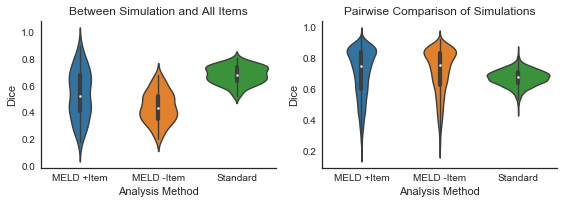

In [298]:
fig,axs = plt.subplots(1,2, figsize = (8,3))
sns.set_style("white")
sns.set_context("paper", font_scale = 1.25)

sns.violinplot(x = 'Analysis Method', y = 'Dice', data = plot_df, ax = axs[0])
axs[0].set_title('Between Simulation and All Items')
sns.violinplot(x = 'Analysis Method', y = 'Dice', data = pw_plot_df, ax = axs[1])
axs[1].set_title('Pairwise Comparison of Simulations')

sns.despine()
fig.tight_layout()
fig.savefig('MELD_fig1.png')

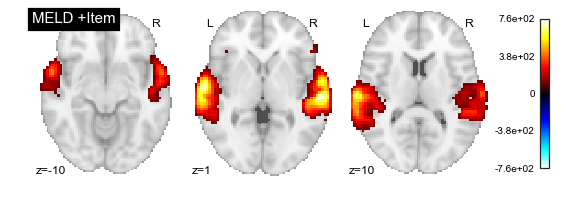

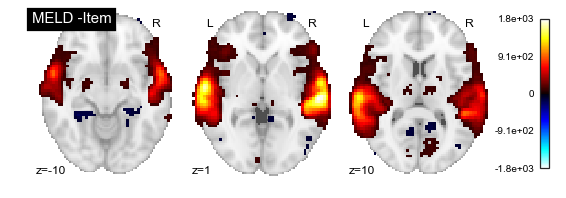

In [324]:
plotting.plot_stat_map(image.load_img(true_path), title = 'MELD +Item', display_mode = 'z', draw_cross = False, cut_coords = [-10, 1, 10])
plotting.plot_stat_map(image.load_img(noi_true_path), title = 'MELD -Item', display_mode = 'z', draw_cross = False, cut_coords = [-10, 1, 10])


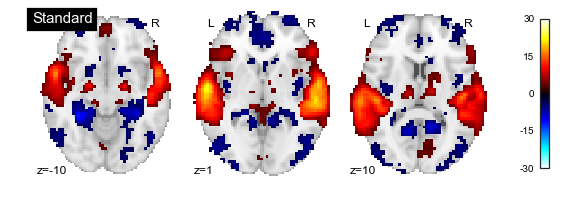

In [322]:
plotting.plot_stat_map(afni_plot, title = 'Standard', vmax = 30, display_mode = 'z', draw_cross = False, cut_coords = [-10, 1, 10])